In [55]:
!pip install noise
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from scipy.special import j1
import noise

In [56]:
# Функция принимает на вход координаты точки (индексы в двумерном массиве), сравнивает среднюю яркость точек в кольце (r_eiri, 3*r_eiri) и в круге r_eiri, и по параметру tolerance и отношению этих яркостей
def is_volcano(data, x, y, tolerance):
    eiri_spot = data[y-r_eiri:y+r_eiri+1, x-r_eiri:x+r_eiri+1]
    surroundings = []
    for i in range(y-3*r_eiri, y+3*r_eiri+1):
        for j in range(x-3*r_eiri, x+3*r_eiri+1):
            if (i > y+r_eiri or i < y-r_eiri) or (j > x+r_eiri or j < x-r_eiri):
                # print(i, j)
                surroundings.append(data[i][j])
    eiri_brightness = np.mean(eiri_spot)
    surroundings_brightness = np.mean(surroundings)

    if eiri_brightness / surroundings_brightness >= tolerance:
        return True
    else:
        return False

# Функция, генерирующая облака с помощью шума Перлина
def generate_fractal_noise(width, height, scale=100.0,
                          octaves=1, persistence=0.5, lacunarity=2.0):
    noise_map = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            x = i / scale
            y = j / scale

            value = 0.0
            frequency = 1.0
            amplitude = 1.0
            max_value = 0.0  # Для нормализации

            for _ in range(octaves):
                # Генерация шума для текущей октавы
                value += noise.snoise2(x * frequency,
                                      y * frequency) * amplitude

                max_value += amplitude
                frequency *= lacunarity
                amplitude *= persistence

            if value > 0.4:
                noise_map[i][j] = 255
            else:
                noise_map[i][j] = 0

    return noise_map

def create_image_from_text_file(filename):
    data = np.loadtxt(filename)

    # Масштабирование значений пикселей (от 0 до 255)
    data_scaled = (np.clip((data+100),0,512) / 511.0) * 255.0
    data_scaled = data_scaled.astype(np.uint8)
    img = Image.fromarray(data_scaled, mode='L')

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img.save("image.png")
    plt.show()

def generate_volcano(x, y, snr, world):#генерирует 1 вулкан, изменяя массив
    coords = []
    #x y - координаты
    #snr - signal noise ratio - отношение сигнала к шуму
    #world - карта мира
    for i in range(-1,2):
        for j in range (-1,2):
            if(0<=x+i<shape[0] and 0<=y+j<shape[1]):world[x+i][y+j] += 100*(np.sqrt(snr)-1)
            coords.append((x,y))#сохранение координат

def generate_volcanos(snr, world):# генерирует от 10 до 20 вулканов на карте, используя предыдущую функцию
    n  = random.randint(10,20)
    for i in range(n):
        x = random.randint(0,1999)
        y = random.randint(0,1999)
        generate_volcano(x, y, snr, world)

In [57]:
# Параметры распределения Гаусса
mu_gauss = 100    # Среднее значение (центр диапазона 0-512)
sigma_gauss = 20  # Стандартное отклонение (подобрано для диапазона 0-512)

# Параметры распределения Коши
loc_cauchy = 100      # Центр распределения
scale_cauchy = 2     # Параметр, отвечающий за ширину пика

# Параметры распределения Лапласа
loc_laplace = 100     # Центр распределения
scale_laplace = 10    # Параметр, отвечающий за ширину пика

# Радиус Эйри вулканов в пикселях
r_eiri = 2

In [58]:
# Размер изображения
shape = (2000, 2000)

# Генерация двумерного массива
array_gauss = np.random.normal(loc=mu_gauss, scale=sigma_gauss, size=shape)
# array_cauchy = loc_cauchy + scale_cauchy * np.random.standard_cauchy(size=shape)
array_laplace = np.random.laplace(loc=loc_laplace, scale=scale_laplace, size=shape)
array_cauchy = sp.stats.cauchy.rvs(loc=loc_cauchy, scale=scale_cauchy, size=shape)

# Суперпозиция шумов, складываем и нормируем
array = (array_gauss + array_cauchy + array_laplace)/3

array = array.astype(int)

# Добавляем облака
noise_map = generate_fractal_noise(width=2000, height=2000,
                                    scale=200.0,
                                    octaves=1,
                                    persistence=0.5,
                                    lacunarity=2.0)
array = array + noise_map

# Обрезка значений за пределами [0, 512]
array = np.clip(array, 0, 512)

generate_volcanos(10, array)

defected_pixels = []#массив координат дефектных точек x, y,  яркость

for i in range(4000):# генерация дефектных точек
    x = random.randint(0,1999)
    y = random.randint(0,1999)
    array[x][y]  = random.randint(450, 512)
    defected_pixels.append([x, y, array[x][y]])


np.savetxt(
    "output.txt",   # Имя файла
    array,          # Массив
    delimiter=" ",  # Разделитель между числами
)

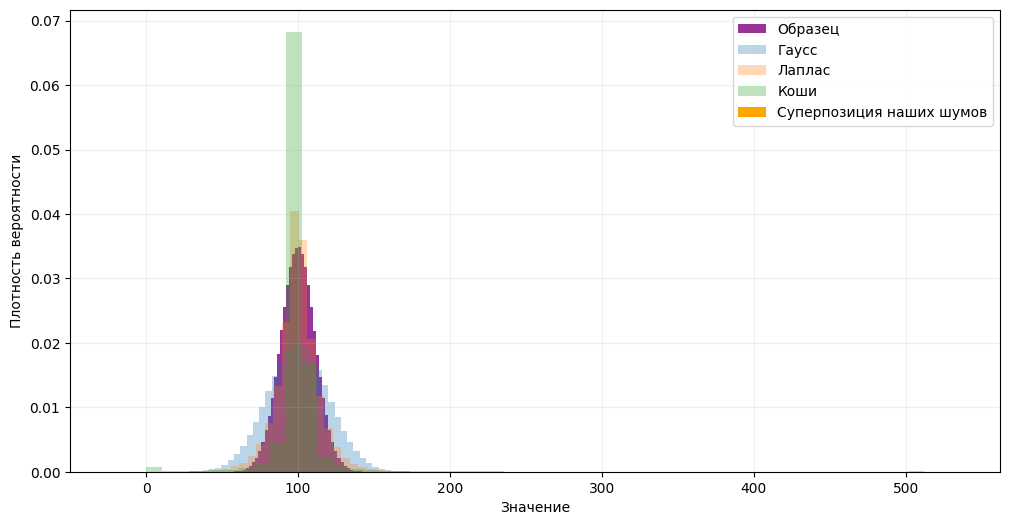

In [66]:
# Построим распределения интенсивности для подбора параметров распределений для максимального совпадения с образцом

data_reference = np.loadtxt("1.txt")

plt.figure(figsize=(12, 6))

plt.hist(data_reference.ravel(), bins=50, density=True, alpha=0.8,
         label="Образец", color="purple")
plt.hist(np.clip(array_gauss.ravel(), 0, 512), bins=50, density=True, alpha=0.3,
         label="Гаусс")
plt.hist(np.clip(array_laplace.ravel(), 0, 512), bins=50, density=True, alpha=0.3,
         label="Лаплас")
plt.hist(np.clip(array_cauchy.ravel(), 0, 512), bins=50, density=True, alpha=0.3,
         label="Коши")
plt.hist(((array_gauss + array_cauchy + array_laplace)/3).ravel(), bins=50, density=True, alpha=1,
         label="Суперпозиция наших шумов", color="orange")

plt.xlabel("Значение")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.grid(alpha=0.2)
plt.xlim(-50, 562)

plt.show()

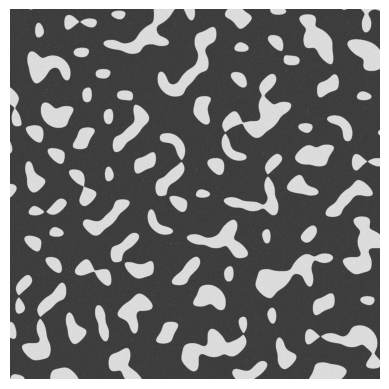

In [60]:
# Отрисовываем полученную нами модель
create_image_from_text_file("output.txt")

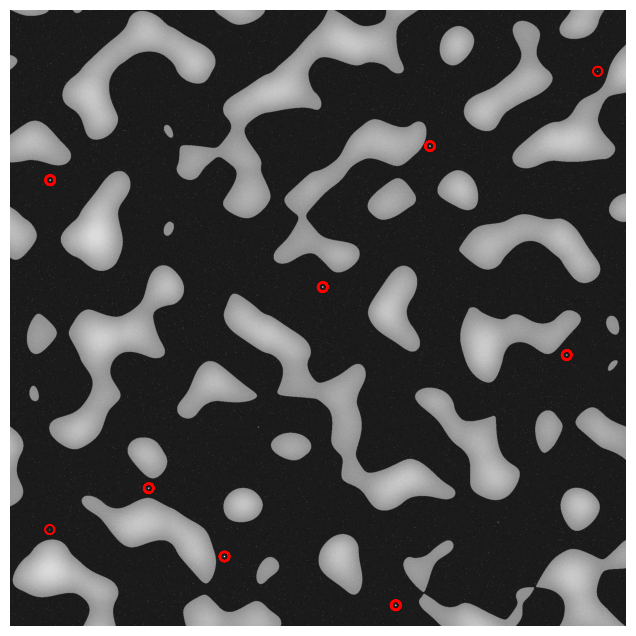

In [61]:
# Проверим функцию для поиска вулканов на примере

# data = np.loadtxt("10.txt")
# data_volcano = []

# for i in range(3*r_eiri, 2000-3*r_eiri-1):
#     for j in range(3*r_eiri, 2000-3*r_eiri-1):
#         print(j, i)
#         if is_volcano(data, j, i, 2):
#             data_volcano.append([j, i])
# ^
# |
# работает долго, выдает:
data_volcano = [[1907, 198], [1908, 198], [1907, 199], [1908, 199], [1363, 439], [1362, 440], [1363, 440], [1364, 440], [1361, 441], [1362, 441], [1363, 441], [1364, 441], [1365, 441], [1362, 442], [1363, 442], [1364, 442], [1365, 442], [1362, 443], [1363, 443], [1364, 443], [129, 550], [130, 550], [131, 550], [128, 551], [129, 551], [130, 551], [131, 551], [132, 551], [128, 552], [129, 552], [130, 552], [131, 552], [132, 552], [128, 553], [129, 553], [130, 553], [131, 553], [129, 554], [130, 554], [131, 554], [1015, 897], [1016, 897], [1014, 898], [1015, 898], [1016, 898], [1017, 898], [1013, 899], [1014, 899], [1015, 899], [1016, 899], [1017, 899], [1013, 900], [1014, 900], [1015, 900], [1016, 900], [1014, 901], [1015, 901], [1806, 1118], [1807, 1118], [1808, 1118], [1806, 1119], [1807, 1119], [1808, 1119], [1809, 1119], [1805, 1120], [1806, 1120], [1807, 1120], [1808, 1120], [1809, 1120], [1805, 1121], [1806, 1121], [1807, 1121], [1808, 1121], [1807, 1122], [450, 1550], [449, 1551], [450, 1551], [451, 1551], [452, 1551], [448, 1552], [449, 1552], [450, 1552], [451, 1552], [452, 1552], [448, 1553], [449, 1553], [450, 1553], [451, 1553], [449, 1554], [450, 1554], [128, 1686], [129, 1686], [128, 1687], [129, 1687], [695, 1772], [696, 1772], [697, 1772], [694, 1773], [695, 1773], [696, 1773], [697, 1773], [698, 1773], [694, 1774], [695, 1774], [696, 1774], [697, 1774], [698, 1774], [694, 1775], [695, 1775], [696, 1775], [697, 1775], [696, 1776], [1252, 1930], [1250, 1931], [1251, 1931], [1252, 1931], [1253, 1931], [1254, 1931], [1250, 1932], [1251, 1932], [1252, 1932], [1253, 1932], [1254, 1932], [1250, 1933], [1251, 1933], [1252, 1933], [1253, 1933], [1254, 1933], [1251, 1934], [1252, 1934], [1253, 1934]]

# Рисуем кружки
data10 = np.loadtxt('10.txt')
circle_radius = 15
circle_color = 'red'

fig, ax = plt.subplots(1, figsize=(8, 8))

ax.imshow(data10, cmap='gray')

for col, row in data_volcano:
    circle = plt.Circle((col, row), radius=circle_radius, color=circle_color, fill=False)
    ax.add_patch(circle)
ax.axis('off')
plt.savefig("image_with_circles.png")
plt.show()